# Data representation
In this tutorial, we'll take a closer look at the reconstruction data is represented in Medusa. The most important features of Medusa's representation of (4D) reconstruction data are the *vertices* and the associated *triangles*, which we'll discuss in detail.

## Vertices

Before going into 4D, let's first focus on *3D* objects. There are many ways in which the shape of a 3D object can be represented digitally, but arguably the most common one is as a [mesh](https://en.wikipedia.org/wiki/Polygon_mesh). The most important element of 3D mesh is its set of *vertices* (singular: vertex), which each define a location in space (and possibly other attributes).

Let's take a look at a set of vertices that make up the template face from the [FLAME](https://flame.is.tue.mpg.de/) topology:

In [2]:
from medusa.data import get_template_flame
template = get_template_flame(topo='coarse', device='cpu')
v = template['v']

# Show shape of vertices
tuple(v.shape)

(5023, 3)

Often, as in the case above, a set of 3D vertices is organized as an $V$ (number of vertices) $\times 3$ (X, Y, Z), where the latter dimension refers to some 3D coordinate system. The values of the vertices refer to the location relative to the coordinate system's origin and, in the case of the FLAME topology, are defined in meters (but could also be in centimeters or millimeters):

In [3]:
# Show values of first vertex
v[0, :]

tensor([ 0.0620,  1.4935, -0.0272])

Each vertex within given topology (like FLAME, or Mediapipe) has a particular semantic meaning. In the context of 3D face shape, this means that each vertex refers to a particular predefined part of the face. For example, vertex $p$ in the FLAME mesh *always* refers to the tip of the nose. Importantly, vertex $p$ in a set of vertices corresponding to one face (face A) and vertex $p$ in a set of vertices corresponding to another face (face A') *both* refer to the tip of the nose (see figure below), but the *values* (i.e., the location of that vertex) of that vertex may differ for you and me. 

![semantic_correspondence](../images/semantic_correspondence.png)

*From Fan et al. (2018). Dense Semantic and Topological Correspondence of 3D Faces without Landmarks. ECCV.*

A fancy term to denote this consistency across meshes of the same topology is sometimes called "semantic correspondence" and is crucial when you want to compare different shapes (of the same topology).

## Triangles

In addition to vertices, a mesh also contains information on how to connect vertices to create surfaces. These surfaces can be made up of any polygon (indeed, meshes are often called *polygon meshes*), but *triangle* meshes are most common as they are very fast to render. In a triangle mesh, the object's shape is thus represented as a collection of triangles, each made up of three vertices. The figure below shows you how this looks like by explicitly showing the edges of each triangle (a "wireframe" rendering):

![mpipe_mesh](https://i.stack.imgur.com/HBa8z.jpg)

```{note}
Often, you'll see triangles (or other polygons) referred to as "faces" (which, I assume, is short for *surfaces*) or simply `f`. To avoid confusion with our object of interest (the human face), we'll use "triangles" instead.
```

Triangles are represented as an $T$ (triangles) $\times 3$ (number of vertices that make up a triangle) array with integers. For example, the (coarse) FLAME mesh consists of 9976 triangles:

In [4]:
# In Medusa, we often refer to triangles as "tris"
tris = template['tris']
tuple(tris.shape)


(9976, 3)

The three integers of each triangle refer to the vertex indices that make up that particular triangle. For example, the first triangle in the `tri` array consists of vertex 3, 1, and 0:

In [5]:
tris[0, :]

tensor([3, 1, 0])

Importantly, the triangles across different meshes (of the same topology) is always the same! So while the vertex values of one face mesh may differ from vertex values of another face mesh (as their face shape probably differs), their triangles will be exactly the same.

When working with Medusa, you probably won't deal with triangles much; they are technically only needed for rendering.

## From 3D to 4D

So far we only talked about how 3D data is represented, but what about *4D* reconstruction data? Indeed, Medusa provides means to reconstruct not just a single 3D face from an image, but a 3D face *from each frame of a video*! The way Medusa represents this 4D data is by an $N$ (number of frames) $\times V$ (number of vertices) $\times 3$ (X, Y, Z). Let's inspect such a vertex array:

In [14]:
from medusa.data import get_example_h5
data_4d = get_example_h5(load=True, model='emoca-coarse', device='cpu')

# Project out global movement (rotation/translation/scale)
data_4d.to_local()

# In Data4d objects, vertices are stored in the `v` attribute
tuple(data_4d.v.shape)

(232, 5023, 3)

As you can see, this 4D reconstruction is based on 232 frames (eaching containing 5023 3D vertices). One way to think about a 4D mesh is as a collection of "signals" that describe the (possibly) changing location of the mesh' vertices over time (that is, their movement!). Importantly, the location is not a single value, but *three*, because a vertex location can change in three ways: left-right (X), up-down (Y), and forward-backward (Z). 

Let's plot a couple of time series. We'll subtract the first frame from each time point to show the relative change in movement (relative to the first frame):

Text(0, 0.5, 'Movement (meter)')

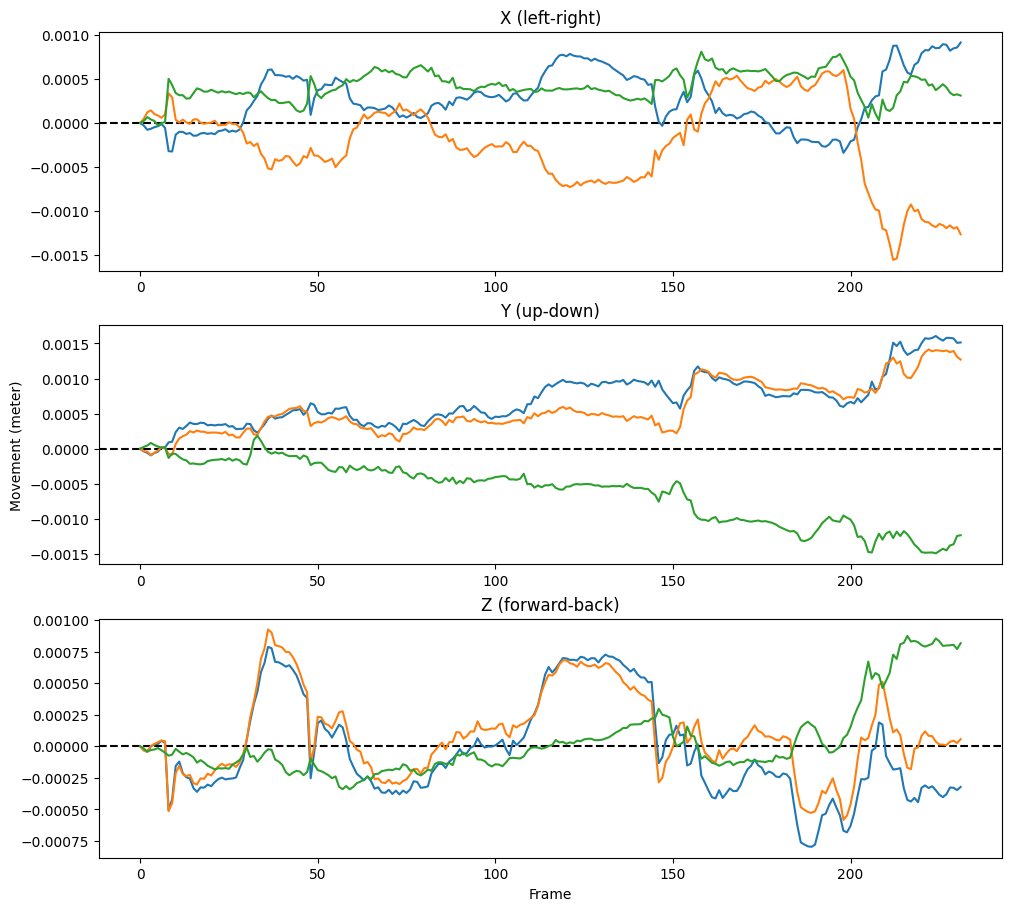

In [25]:
import matplotlib.pyplot as plt

v_idx = [22, 521, 4888]
v_numpy = data_4d.v.numpy()
v_numpy -= v_numpy[0, None, ...]

fig, axes = plt.subplots(nrows=3, figsize=(10, 9), constrained_layout=True)

for ax in axes:
    ax.axhline(0, ls='--', c='k')

axes[0].plot(v_numpy[:, v_idx, 0])
axes[0].set_title("X (left-right)")
axes[1].plot(v_numpy[:, v_idx, 1])
axes[1].set_title("Y (up-down)")
axes[2].plot(v_numpy[:, v_idx, 2])
axes[2].set_title("Z (forward-back)")
axes[2].set_xlabel("Frame")
axes[1].set_ylabel("Movement (meter)")


It is these "signals" or "time series" that you can use as measurments of facial movement and analyze as such. In the [analysis tutorial](./analysis), we discuss some ways in which one can go about doing this.